<IPython.core.display.Javascript object>


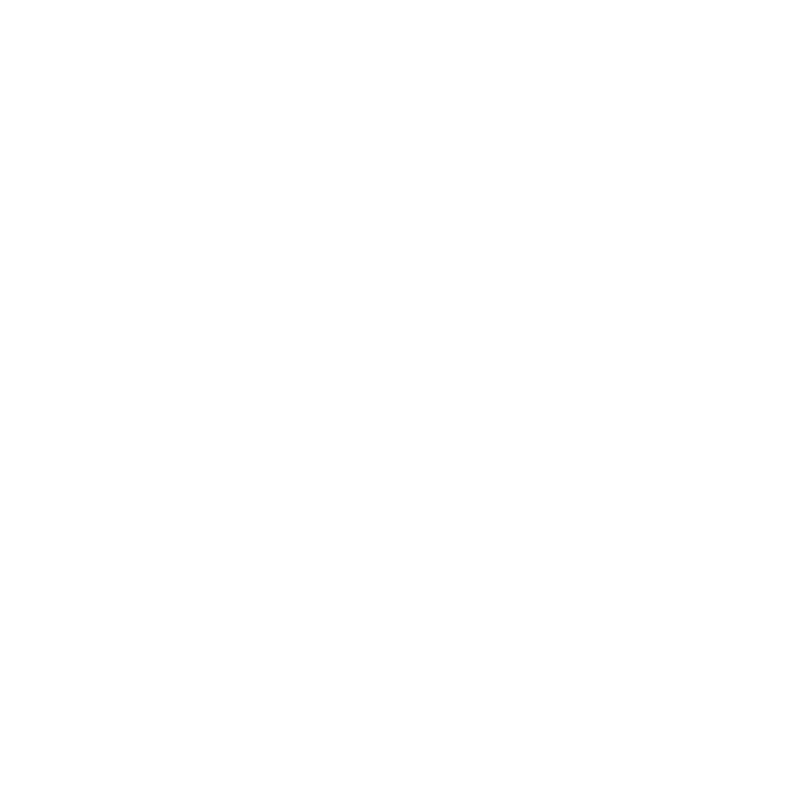

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
%matplotlib notebook

def plot_cantons():
    locations = pd.read_csv('longitudelatitude.csv', index_col=0)
    long = locations['Longitude'].iloc[:-1].values
    lat = locations['Latitude'].iloc[:-1].values
   
    plt.figure(figsize=(8,8))
    plt.scatter(long, lat, c='r', alpha=0.7, s=200)
    return mplleaflet.display()

plot_cantons()

In [8]:
import numpy as np
import pandas as pd

# Clean and setup the language data
def getData():
    df = pd.read_csv('languages.csv')
    df = df[['Code', 'Canton of','Official languages']]
    df =df.set_index('Canton of')

    for language in ['German', 'French', 'Italian', 'Romansh']:
        df[language]=[language in df['Official languages'].loc[canton] for canton in df.index]
        df.loc['Switzerland',(language)]=False

    # Clean and setup the population data
    pop = pd.read_csv('population.csv')
    db = pd.DataFrame(index = pop['code'].unique())

    for year in range(2010,2017):
        mask = (pop['type']=='Permanent resident population') & (pop['year']==year)
        string = str(year)+ 'p'
        db.loc[:,string] = pop['population'].loc[mask].values

        mask = (pop['type']=='Non permanent resident population') & (pop['year']==year)
        string = str(year)+ 'n'
        db.loc[:,string] = pop['population'].loc[mask].values
   
        db[str(year)+'t']=db[str(year)+'p']+db[str(year)+'n']
    # Open the gdp data
    gdp = pd.read_csv('gdp.csv')
    gdp = gdp.rename(index=str, columns={"2015p": "2015"})

    for year in [str(num) for num in range(2008, 2016)]:
        gdp[year] = gdp[year].str.strip()
        gdp[year] = gdp[year].str.replace(',', '')
        gdp[year] = pd.to_numeric(gdp[year])

    gdp.index = gdp['Canton']

    # Open the longitude and latitude values
    locations = pd.read_csv('longitudelatitude.csv', index_col=0)

    # Join the data sets appropriately
    dk = pd.concat([df, gdp], axis=1, join='inner')
    dk = dk.set_index('Code')

    dk = pd.concat([dk, db], axis=1, join='inner')

    dk = pd.concat([dk, locations], axis=1, join='inner')

    #Change the gdp values to gdp per person
    for year in range(2010,2016):
   
        dk[str(year)]= dk.apply(lambda row: (1000000)*row[str(year)]/row[str(year)+'t'], axis=1)

    dk = dk.drop(['Official languages', '2008', '2009', '2016p', '2016n', '2016t'], axis=1)
    return dk
def plotLine(dk):
    years = [str(year) for year in range(2010, 2016)]
    german = dk.groupby( ['German'] )[years].mean().loc[True].values
    french = dk.groupby( ['French'] )[years].mean().loc[True].values
    italian = dk.groupby( ['Italian'] )[years].mean().loc[True].values
    romansh = dk.groupby( ['Romansh'] )[years].mean().loc[True].values

    plt.plot(np.arange(6), german, '--', color='red', label='German Speaking Cantons')
    plt.plot(np.arange(6), french, '--', color='blue', label='French Speaking Cantons')
    plt.plot(np.arange(6), italian, '--', color='green', label='Italian Speaking Cantons')
    plt.plot(np.arange(6), romansh, '--', color='yellow', label='Romansh Speaking Cantons')
    plt.plot(np.arange(6), dk[years].loc['CH'].values, '--', color='black', label='All of Switzerland')
    plt.xticks(np.arange(len(years)), years)
    #plt.yticks([0, 50000, 100000, 150000])
    #plt.legend()
    
def plotNon(dk):
    years = [str(year)+'n' for year in range(2010, 2016)]
    german = dk.groupby( ['German'] )[years].mean().loc[True].values
    french = dk.groupby( ['French'] )[years].mean().loc[True].values
    italian = dk.groupby( ['Italian'] )[years].mean().loc[True].values
    romansh = dk.groupby( ['Romansh'] )[years].mean().loc[True].values

    plt.plot(np.arange(6), german, '--', color='red', label='German Speaking Cantons')
    plt.plot(np.arange(6), french, '--', color='blue', label='French Speaking Cantons')
    plt.plot(np.arange(6), italian, '--', color='green', label='Italian Speaking Cantons')
    plt.plot(np.arange(6), romansh, '--', color='yellow', label='Romansh Speaking Canton')
    #plt.plot(np.arange(6), dk[years].loc['CH'].values, '--', color='black', label='All of Switzerland')
    plt.plot(np.arange(6), dk[years].loc['ZH'].values, '--', color='teal', label='Canton of Zürich')
    #plt.legend()
def getColor(row):
    if row['Romansh']:
        return 'yellow'
    elif row['Italian']:
        return 'green'
    elif row['French']:
        return 'blue'
    elif row['German']:
        return 'red'
    else:
        return 'black'

In [47]:
def onclick(event):
    years = [str(year) for year in range(2010, 2016)]
    plt.subplot(2, 1, 2)

    bars = get_bars(dk)
    cantonInterest = bars.index[round(float(event.xdata))]
    plotBar(dk)
    
    plt.subplot(2, 2, 1)
    #plotLine(dk)
    plt.plot(np.arange(6), dk[years].loc[cantonInterest].values, '-o', color='tan',
             label='Canton of '+dk['Canton'].loc[cantonInterest])
    plt.gca().set_title('Canton {} chosen'.format(cantonInterest))
    #plt.legend(bbox_to_anchor=(10.05, 1), loc=2, borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(.975, 1.0, 0.0))#, bbox_transform=plt.gcf().transFigure)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def get_bars(dk):
    years = [str(year) for year in range(2010, 2016)]
    bars = dk[years].apply(lambda row: np.mean(row[years]), axis=1)
    bars.sort_values(inplace=True, ascending=False)
    return bars
    
def plotBar(dk):#, cantonIndex):
    bars = get_bars(dk)
    #color = [(1,0,0) for canton in bars]
    colors = dk[['German', 'French', 'Italian', 'Romansh']].apply(lambda row: getColor(row), axis=1)
    colors = colors.reindex(bars.index)
    #color[cantonIndex]=(0,0,1)
    plt.bar(np.arange(len(dk)), bars.values, width = .5, edgecolor = 'black', color=colors)
    plt.xticks(np.arange(len(bars)), bars.index)
    plt.yticks([0, 50000, 100000, 150000])
    a = plt.gca().xaxis

# rotate the tick labels for the x axis
    for item in a.get_ticklabels():
        item.set_rotation(315)
# adjust the subplot so the text doesn't run off the image
    plt.subplots_adjust(bottom=0.25)


In [2]:
# standard imports
import ipympl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.get_backend()

'module://ipympl.backend_nbagg'

<IPython.core.display.Javascript object>


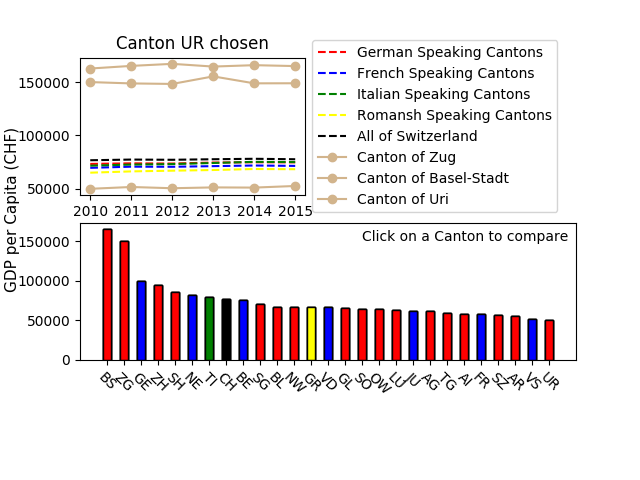

In [48]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def onclick2(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

dk = getData()
# Plot the line Graph
plt.figure()

ax = plt.gca()

figsize=(10,10)
plt.subplot(2, 1, 2)
plt.text(-6, 280000,'GDP per Capita (CHF)', size=11, rotation=90)
plt.text(15, 150000,'Click on a Canton to compare', size=10, rotation=0)
plotBar(dk)
# tell mpl_connect we want to pass a 'button_press_event' into onclick when the event is detected
plt.gcf().canvas.mpl_connect('button_press_event', onclick)

plt.subplot(2, 2, 1)
plotLine(dk)
plt.title('Swiss Cantonal GDP by language')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.subplot(3, 1, 2)
#plotNon(dk)
plt.show()

In [12]:
matplotlib.get_backend()

'nbAgg'

<IPython.core.display.Javascript object>


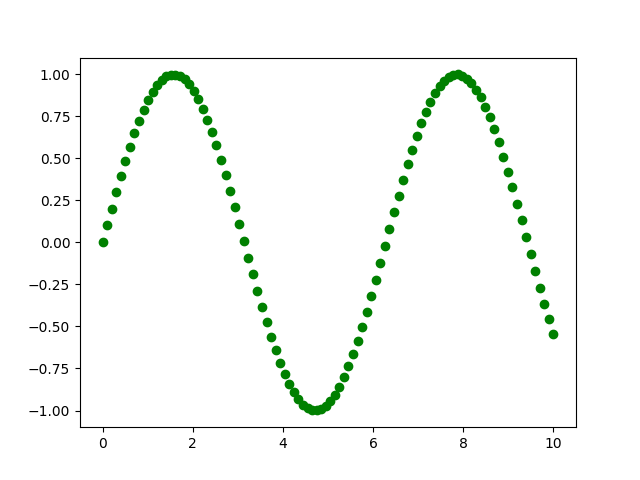

In [13]:
import matplotlib
import itertools
import numpy as np
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots()
x = np.linspace(0,10,100)
y = np.sin(x)
ln, = ax.plot(x,y, 'o', picker=5)
evt = []
colors = iter(itertools.cycle(['r', 'g', 'b', 'k', 'c']))
def on_event(event):
    evt.append(event)
    ln.set_color(next(colors))
    fig.canvas.draw()
    fig.canvas.draw_idle()
fig.canvas.mpl_connect('key_press_event', on_event)
fig.canvas.mpl_connect('pick_event', on_event)
plt.show()

In [7]:
import matplotlib.pyplot as plt
plt.ion()
plt.plot([1.6, 2.7])

In [43]:
round(3.5399)
years = [str(year) for year in range(2010, 2016)]
years

['2010', '2011', '2012', '2013', '2014', '2015']

In [45]:
bars = get_bars(dk)
bars.index, bars.index[4]
np.ones(6)*70000,np.arange(6)
cantonInterest='ZG'
years = [str(year) for year in range(2010, 2016)]
dk[years].loc[cantonInterest].values

array([150356.47115427, 149096.06218062, 148608.93499894, 155721.13537264,
       149178.94079666, 149239.88122135])

<IPython.core.display.Javascript object>


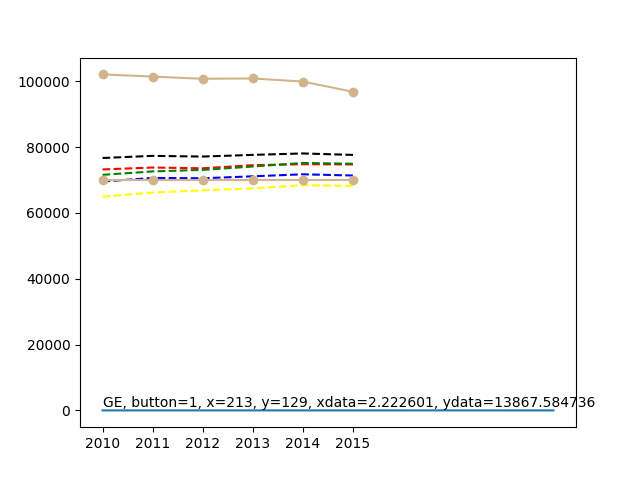

In [46]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")
years = [str(year) for year in range(2010, 2016)]

def onclick(event):
    bars = get_bars(dk)
    cantonInterest = bars.index[round(float(event.xdata))]
    plt.plot(np.arange(6), dk[years].loc[cantonInterest].values, '-o', color='tan',label='Canton of '+dk['Canton'].loc[cantonInterest])
    #plt.plot(np.arange(6), np.ones(6)*70000, '-o', color='tan')
    tx = cantonInterest+', button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
dk = getData()
plotLine(dk)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


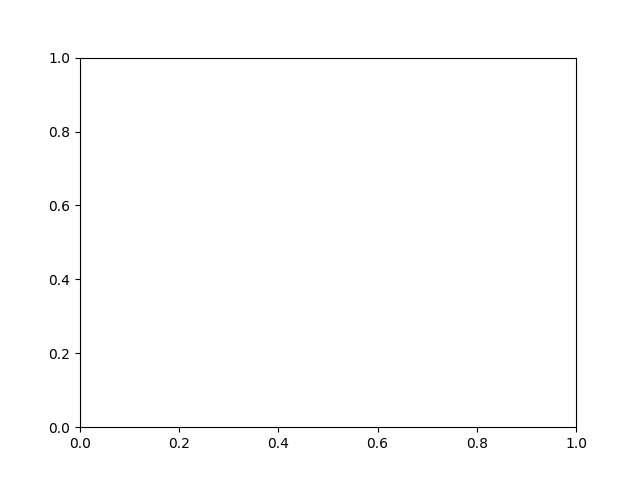

In [5]:

def on_press(event):
    print('you pressed', event.button, event.xdata, event.ydata)
fig, ax = plt.subplots()
cid = fig.canvas.mpl_connect('button_press_event', on_press)

In [3]:
import ipympl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

fig, ax = plt.subplots()
ax.plot(np.random.rand(10))


def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

A Jupyter Widget